# Convolutional Neural Networks

In this study, we are interested in evaluating the performance of a Convolutional Neural Network using different hyperparameters. The goal is to build a model that can recognize the content of an image, in this particular case, recognize if the image processed is of a cat or a dog. Six models will be tested and confronted. Hyperparameters that will be taken into consideration are the number of layers, the number of nodes per layer and the number of epoch. Images of size 64x64 and 128x128 will be tested. Four different combinations of layers and  number of nodes will be tested; then, the best one will be applied to the 128x128 images. The last model will be modified to add more pooling layers and dropout layers to decrease overfitting and improve the score. The number of nodes per layer Only grayscale image will be used since the hardware used had difficulties in handling larger files.
The results will be evaluated using the Kaggle score in the Cats vs Dog competition too.

## Import packages

In [1]:
import os
import time
import cv2
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 
import tensorflow as tf
import tflearn
import sys
import matplotlib.pyplot as plt

from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

# suppress warning messages
def warn(*args, **kwargs): 
    pass
import warnings 
warnings.warn = warn

tf.disable_v2_behavior() 
RANDOM_SEED=1234








Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def label_image(img):
    world_label = img.split('.')[0]
    if world_label == "dog": return [1, 0]
    elif world_label == 'cat': return [0, 1]
    
    
def create_training_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_image(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        img = img / 255
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save("training_data.npy", training_data)
    return training_data
        
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        img = img / 255
        testing_data.append([np.array(img), np.array(img_num)])
#   np.save("testing_data.npy", testing_data)
    return testing_data  

def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

## Data preparation for the model

The training data consist in 25.000 labeled images of cats and dogs, while the testing data contain 12.500 not labeled mixed pictures of cats and dogs.

In [3]:
os.getcwd()

'/Users/vittoriopro/Documents/AI/MSDS/422/Module7/Assignment7'

In [4]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'
IMG_SIZE = 64

training_data = create_training_data()
#training_data = np.load('training_data.npy')

100%|██████████| 25000/25000 [01:25<00:00, 292.94it/s]


In [5]:
test_data = process_test_data()

100%|██████████| 12500/12500 [00:38<00:00, 322.96it/s]


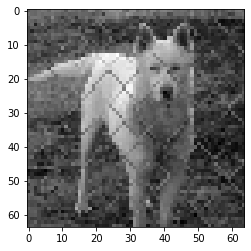

In [6]:
fig=plt.figure()

image1 = training_data[1]


plt.imshow(image1[0],cmap='gray')


In [7]:
# Initialize metrics
metrics = {}
# Initialize metric names
names = ['Model number', 'Nodes per Layer', 'Time in Seconds', 'Validation accuracy']

TRAIN_SIZE = 25000
VAL_SIZE = 2500
#TEST_SIZE = 5000

# Set fixed parameters for models
LR = 0.001



In [8]:
N_EPOCH = 10

## Model 1

In this model, we will use 3 hidden layers composed of 64 nodes each, with a pooling layer for each of them. Than 2 fully connected layers, the first one followed by a dropout layer. The accuracy of the training and validation set are displayed, along with the total execution time. The resulting prediction is stored in a CSV file to be uploaded in Kaggle for testing. The number of epoch tested is 10.

In [9]:
###### Model 1
print('Model 1')

# Reset the session
tf.reset_default_graph()
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

MODEL_NAME = "Model1{}-{}.model".format(LR, '3conv')

# Start timer
start = time.clock()


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log') 

# train = training_data[: -5000]
# val = training_data[-5000:]
# test = training_data

train = training_data[:(TRAIN_SIZE-VAL_SIZE)]
train2 = training_data[:TRAIN_SIZE]
val = train2[-VAL_SIZE:]
#test = training_data[-TEST_SIZE:]


X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train])
x_val = np.array([i[0] for i in val]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array([i[1] for i in val])

#X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#y_test = np.array([i[1] for i in test])

print(len(X), len(Y), len(x_val), len(y_val))
print(np.shape(X), len(Y), len(x_val), len(y_val))


    
model.fit({'input': X}, {'targets': Y}, n_epoch=N_EPOCH, validation_set=({'input': x_val}, {'targets': y_val}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

# Record the clock time it takes
duration = round((time.clock() - start ) / 60, 2)
print('Duration in minutes:', duration)

acc_val  = model.evaluate(x_val, y_val)
print('Validation accuracy :', acc_val)
#acc_test  = model.evaluate(X_test, y_test)

metrics['Model 1 64x64'] = [N_EPOCH,'3 layers, 64 nodes flat', duration, acc_val]



Training Step: 3519  | total loss: 0.11502 | time: 83.625s
| Adam | epoch: 010 | loss: 0.11502 - acc: 0.9756 -- iter: 22464/22500
Training Step: 3520  | total loss: 0.10789 | time: 85.868s
| Adam | epoch: 010 | loss: 0.10789 - acc: 0.9780 | val_loss: 0.54677 - val_acc: 0.8248 -- iter: 22500/22500
--
Duration in minutes: 45.08
Validation accuracy : [0.8248000001907348]


The predictions are calculated for this model and saved in csv file for submission in Kaggle.

In [10]:


with open("Subm-Model1.csv",'w') as f:
    f.write('id,label\n')
with open("Subm-Model1.csv",'a') as f:
    for num, data in enumerate(test_data):
        if num%1000 == 0: print('write {} line'.format(num))
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[0]))
print('done')

write 0 line
write 1000 line
write 2000 line
write 3000 line
write 4000 line
write 5000 line
write 6000 line
write 7000 line
write 8000 line
write 9000 line
write 10000 line
write 11000 line
write 12000 line
done


## Model 2

In this model, we will use 6 hidden layers composed of 32, 64, 128, 128, 64, 32 nodes. The rest of the structure remains unchanged from the previous model. The accuracy of the training and validation set are displayed, along with the total execution time. The resulting prediction is stored in a CSV file to be uploaded in Kaggle for testing.

In [11]:
###### Model 2
print('Model 2')

# Reset the session
tf.reset_default_graph()
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

MODEL_NAME = "Model2{}-{}.model".format(LR, '6conv')

# Start timer
start = time.clock()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 128, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 128, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log') 

train = training_data[:(TRAIN_SIZE-VAL_SIZE)]
train2 = training_data[:TRAIN_SIZE]
val = train2[-VAL_SIZE:]
#test = training_data[-TEST_SIZE:]


X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train])
x_val = np.array([i[0] for i in val]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array([i[1] for i in val])

#X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#y_test = np.array([i[1] for i in test])

print(len(X), len(Y), len(x_val), len(y_val))
print(np.shape(X), len(Y), len(x_val), len(y_val))


    
model.fit({'input': X}, {'targets': Y}, n_epoch=N_EPOCH, validation_set=({'input': x_val}, {'targets': y_val}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

# Record the clock time it takes
duration = round((time.clock() - start ) / 60, 2)
print('Duration in minutes:', duration)

acc_val  = model.evaluate(x_val, y_val)
print('Validation accuracy :', acc_val)

#acc_test  = model.evaluate(X_test, y_test)


metrics['Model 2 64x64'] = [N_EPOCH,'6 layers, pyramid', duration, acc_val]

Training Step: 3519  | total loss: 0.15228 | time: 64.236s
| Adam | epoch: 010 | loss: 0.15228 - acc: 0.9488 -- iter: 22464/22500
Training Step: 3520  | total loss: 0.14639 | time: 66.014s
| Adam | epoch: 010 | loss: 0.14639 - acc: 0.9508 | val_loss: 0.49634 - val_acc: 0.8180 -- iter: 22500/22500
--
Duration in minutes: 34.51
Validation accuracy : [0.8179999999046326]


The prediction are calculated for this model and saved in csv file for submission in Kaggle.

In [12]:
with open("Subm-Model2.csv",'w') as f:
    f.write('id,label\n')
with open("Subm-Model2.csv",'a') as f:
    for num, data in enumerate(test_data):
        if num%1000 == 0: print('write {} line'.format(num))
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[0]))
print('done')

write 0 line
write 1000 line
write 2000 line
write 3000 line
write 4000 line
write 5000 line
write 6000 line
write 7000 line
write 8000 line
write 9000 line
write 10000 line
write 11000 line
write 12000 line
done


## Model 3

In this model, we will use 6 hidden layers composed of 32 nodes each. The rest of the structure remains unchanged from the previous model. The accuracy of the training and validation set are displayed, along with the total execution time. The resulting prediction is stored in a CSV file to be uploaded in Kaggle for testing.

In [13]:
###### Model 3
print('Model 3')

# Reset the session
tf.reset_default_graph()
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

MODEL_NAME = "Model3{}-{}.model".format(LR, '7conv')

# Start timer
start = time.clock()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log') 

train = training_data[:(TRAIN_SIZE-VAL_SIZE)]
train2 = training_data[:TRAIN_SIZE]
val = train2[-VAL_SIZE:]
#test = training_data[-TEST_SIZE:]


X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train])
x_val = np.array([i[0] for i in val]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array([i[1] for i in val])

# X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# y_test = np.array([i[1] for i in test])


    
model.fit({'input': X}, {'targets': Y}, n_epoch=N_EPOCH, validation_set=({'input': x_val}, {'targets': y_val}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

# Record the clock time it takes
duration = round((time.clock() - start ) / 60, 2)
print('Duration in minutes:', duration)

acc_val  = model.evaluate(x_val, y_val)
print('Validation accuracy :', acc_val)

# acc_test  = model.evaluate(X_test, y_test)

metrics['Model 3 64x64'] = [N_EPOCH,'6 layers, 32 nodes flat', duration, acc_val]

Training Step: 3519  | total loss: 0.41548 | time: 41.538s
| Adam | epoch: 010 | loss: 0.41548 - acc: 0.8113 -- iter: 22464/22500
Training Step: 3520  | total loss: 0.43188 | time: 42.697s
| Adam | epoch: 010 | loss: 0.43188 - acc: 0.8052 | val_loss: 0.43214 - val_acc: 0.7940 -- iter: 22500/22500
--
Duration in minutes: 21.17
Validation accuracy : [0.7939999996185303]


In [14]:
with open("Subm-Model3.csv",'w') as f:
    f.write('id,label\n')
with open("Subm-Model3.csv",'a') as f:
    for num, data in enumerate(test_data):
        if num%1000 == 0: print('write {} line'.format(num))
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[0]))
print('done')

write 0 line
write 1000 line
write 2000 line
write 3000 line
write 4000 line
write 5000 line
write 6000 line
write 7000 line
write 8000 line
write 9000 line
write 10000 line
write 11000 line
write 12000 line
done


## Model 4

In this model, we will use 6 hidden layers composed of 32, 64, 96, 128, 160, and 192 nodes. The rest of the structure remains unchanged from the previous model. The accuracy of the training and validation set are displayed, along with the total execution time. The resulting prediction is stored in a CSV file to be uploaded in Kaggle for testing.

In [15]:
###### Model 4
print('Model 4')

# Reset the session
tf.reset_default_graph()
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

MODEL_NAME = "Model4{}-{}.model".format(LR, '7conv')

# Start timer
start = time.clock()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 96, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 128, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 160, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 192, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log') 

train = training_data[:(TRAIN_SIZE-VAL_SIZE)]
train2 = training_data[:TRAIN_SIZE]
val = train2[-VAL_SIZE:]
# test = training_data[-TEST_SIZE:]


X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train])
x_val = np.array([i[0] for i in val]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array([i[1] for i in val])

# X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# y_test = np.array([i[1] for i in test])

    
model.fit({'input': X}, {'targets': Y}, n_epoch=N_EPOCH, validation_set=({'input': x_val}, {'targets': y_val}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

# Record the clock time it takes
duration = round((time.clock() - start ) / 60, 2)
print('Duration in minutes:', duration)

acc_val  = model.evaluate(x_val, y_val)
print('Validation accuracy :', acc_val)

# acc_test  = model.evaluate(X_test, y_test)

metrics['Model 4 64x64'] = [N_EPOCH,'6 layers, funnel', duration, acc_val]



Training Step: 3519  | total loss: 0.15272 | time: 61.266s
| Adam | epoch: 010 | loss: 0.15272 - acc: 0.9415 -- iter: 22464/22500
Training Step: 3520  | total loss: 0.15669 | time: 62.962s
| Adam | epoch: 010 | loss: 0.15669 - acc: 0.9380 | val_loss: 0.42449 - val_acc: 0.8420 -- iter: 22500/22500
--
Duration in minutes: 33.18
Validation accuracy : [0.8420000003814697]


In [16]:
with open("Subm-Model4.csv",'w') as f:
    f.write('id,label\n')
with open("Subm-Model4.csv",'a') as f:
    for num, data in enumerate(test_data):
        if num%1000 == 0: print('write {} line'.format(num))
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[0]))
print('done')

write 0 line
write 1000 line
write 2000 line
write 3000 line
write 4000 line
write 5000 line
write 6000 line
write 7000 line
write 8000 line
write 9000 line
write 10000 line
write 11000 line
write 12000 line
done


## Benchmark results.

In the below table, a summary of the 4 models, their characteristics, and performances are shown.

In [17]:

# Convert metrics dictionary to dataframe for display
results_summary = pd.DataFrame.from_dict(metrics, orient='index')
results_summary.columns = names

# Sort by model number
results_summary.reset_index(inplace=True)
results_summary.sort_values(by=['index'], axis=0, inplace=True)
results_summary.set_index(['index'], inplace=True)
results_summary.index.name = None

In [18]:
mod4_results_summary = results_summary

In [19]:
mod4_results_summary 

,Model number,Nodes per Layer,Time in Seconds,Validation accuracy
Model 1 64x64,10,"3 layears, 64 nodes flat",45.08,[0.8248000001907348]
Model 2 64x64,10,"6 layears, pyramid",34.51,[0.8179999999046326]
Model 3 64x64,10,"6 layears, 32 nodes flat",21.17,[0.7939999996185303]
Model 4 64x64,10,"6 layears, funnel",33.18,[0.8420000003814697]


In [ ]:
Kaggle scores and model selection

Model 1 score: 0.58372
Model 2 score: 0.52414
Model 3 score: 0.44403
Model 4 score: 0.46368

Model 4 has better performance in terms of accuracy. Modeel 4 has better processing time in respect to the one with similar accuracy and the kaggle score is 2nd best, so we will select it for further testing and improvements.

## Model 5

We will now use the best model obtained in the previous testing applied on grayscale images of 128x128, keeping the number of epoch to 10 to avoid overfitting.

In [20]:

TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'
IMG_SIZE = 128

training_data = create_training_data()
#training_data = np.load('training_data.npy')
test_data = process_test_data()

100%|██████████| 12500/12500 [00:50<00:00, 247.24it/s]


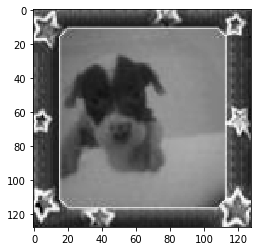

In [21]:
fig=plt.figure()

image1 = training_data[1]


plt.imshow(image1[0],cmap='gray')


In [22]:
###### Model 5
print('Model 5')

N_EPOCH = 10

# Reset the session
tf.reset_default_graph()
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

MODEL_NAME = "Model4{}-{}.model".format(LR, '7conv')

# Start timer
start = time.clock()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 96, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 128, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 160, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 192, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log') 

train = training_data[:(TRAIN_SIZE-VAL_SIZE)]
train2 = training_data[:TRAIN_SIZE]
val = train2[-VAL_SIZE:]
# test = training_data[-TEST_SIZE:]


X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train])
x_val = np.array([i[0] for i in val]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array([i[1] for i in val])

# X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# y_test = np.array([i[1] for i in test])

    
model.fit({'input': X}, {'targets': Y}, n_epoch=N_EPOCH, validation_set=({'input': x_val}, {'targets': y_val}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

# Record the clock time it takes
duration = round((time.clock() - start ) / 60, 2)
print('Duration in minutes:', duration)

acc_val  = model.evaluate(x_val, y_val)
print('Validation accuracy :', acc_val)

#acc_test  = model.evaluate(X_test, y_test)

metrics['Model 5 128x128'] = [N_EPOCH,'6 layers, funnel', duration, acc_val]

Training Step: 3519  | total loss: 0.07428 | time: 232.700s
| Adam | epoch: 010 | loss: 0.07428 - acc: 0.9788 -- iter: 22464/22500
Training Step: 3520  | total loss: 0.07111 | time: 239.187s
| Adam | epoch: 010 | loss: 0.07111 - acc: 0.9793 | val_loss: 0.30203 - val_acc: 0.9036 -- iter: 22500/22500
--
Duration in minutes: 124.86
Validation accuracy : [0.9036000000953675]


In [23]:
with open("Subm-Model5.csv",'w') as f:
    f.write('id,label\n')
with open("Subm-Model5.csv",'a') as f:
    for num, data in enumerate(test_data):
        if num%1000 == 0: print('write {} line'.format(num))
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[0]))
print('done')

write 0 line
write 1000 line
write 2000 line
write 3000 line
write 4000 line
write 5000 line
write 6000 line
write 7000 line
write 8000 line
write 9000 line
write 10000 line
write 11000 line
write 12000 line
done


## Model 6

To further improve the algorithm, droputs layers and funnel strucutre is used for a final test.
We will now use the best model obtained in the previous testing applied on grayscale images of 128x128, keeping the number of epoch to 10 to avoid overfitting. The filter size is 3x3 instead of 2x2.

In [88]:
###### Model 6
print('Model 6')


N_EPOCH = 15

# Reset the session
tf.reset_default_graph()
tf.set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

MODEL_NAME = "Model6{}-{}.model".format(LR, '6conv_4droput')

# Start timer
start = time.clock()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = dropout(convnet, 0.8)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = dropout(convnet, 0.8)

convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log') 

train = training_data[:(TRAIN_SIZE-VAL_SIZE)]
train2 = training_data[:TRAIN_SIZE]
val = train2[-VAL_SIZE:]
#test = training_data[-TEST_SIZE:]


X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train])
x_val = np.array([i[0] for i in val]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array([i[1] for i in val])

#X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# y_test = np.array([i[1] for i in test])

    
model.fit({'input': X}, {'targets': Y}, n_epoch=N_EPOCH, validation_set=({'input': x_val}, {'targets': y_val}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

# Record the clock time it takes
duration = round((time.clock() - start ) / 60, 2)
print('Duration in minutes:', duration)

acc_val  = model.evaluate(x_val, y_val)
print('Validation accuracy :', acc_val)
#acc_test  = model.evaluate(X_test, y_test)


metrics['Model 6 128x128'] = [N_EPOCH,'6 layers, funnel dropout', duration, acc_val]

Training Step: 5279  | total loss: 0.08376 | time: 1086.247s
| Adam | epoch: 015 | loss: 0.08376 - acc: 0.9834 -- iter: 22464/22500
Training Step: 5280  | total loss: 0.07680 | time: 1120.800s
| Adam | epoch: 015 | loss: 0.07680 - acc: 0.9851 | val_loss: 0.45564 - val_acc: 0.8876 -- iter: 22500/22500
--
Duration in minutes: 949.44
Validation accuracy : [0.8875999992370606]


In [89]:
with open("Subm-Model6.csv",'w') as f:
    f.write('id,label\n')
with open("Subm-Model6.csv",'a') as f:
    for num, data in enumerate(test_data):
        if num%1000 == 0: print('write {} line'.format(num))
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[0]))
print('done')

write 0 line
write 1000 line
write 2000 line
write 3000 line
write 4000 line
write 5000 line
write 6000 line
write 7000 line
write 8000 line
write 9000 line
write 10000 line
write 11000 line
write 12000 line
done


# Benchmark results for all models.

In the below table, a summary of the models, their characteristics, and performances are shown.

In [84]:

# Convert metrics dictionary to dataframe for display
results_summary = pd.DataFrame.from_dict(metrics, orient='index')
results_summary.columns = names

# Sort by model number
results_summary.reset_index(inplace=True)
results_summary.sort_values(by=['index'], axis=0, inplace=True)
results_summary.set_index(['index'], inplace=True)
results_summary.index.name = None

In [85]:
tot_results_summary = results_summary

In [86]:
tot_results_summary

,Model number,Nodes per Layer,Time in Seconds,Validation accuracy
Model 1 64x64,10,"6 layers, 64 nodes flat",45.08,[0.8248000001907348]
Model 2 64x64,10,"6 layers, pyramid",34.51,[0.8179999999046326]
Model 3 64x64,10,"6 layers, 32 nodes flat",21.17,[0.7939999996185303]
Model 4 64x64,10,"6 layers, funnel",33.18,[0.8420000003814697]
Model 5 128x128,10,"6 layers, funnel",124.86,[0.9036000000953675]
Model 6 128x128,10,"6 layers, funnel dropout",578.00,[0.8764000004768372]


# Conclusions

Model 1 score: 0.58372
Model 2 score: 0.52414
Model 3 score: 0.44403
Model 4 score: 0.46368
Model 5 score: 0.38238
Model 6 score: 0.42949

kaggle user di: Vittorio Pepe

The best models on the test set are Model 5 and Model 6. Model 6 is very similar to Model 5,and a larger number of epoch would probably give better accuracy results.

Confronting with the other models, increasing the number of layers increase the accuracy of the model. 
The model with the number of nodes per layers increasing (like a funnel) seems to have a better overall performance.  
Increasing the resolution of the pictures improve the accuracy too.
All models are strongly affected by the size of the training dataset: a larger dataset ensures a better accuracy.
The execution times can be quite long, so powerfull CPU/GPU should be used.

 